In [1]:
import torch
from transformers import BertTokenizer
from transformers import BertModel, BertConfig, BertForSequenceClassification
from tqdm.autonotebook import tqdm
import pandas as pd
import numpy as np
tqdm.pandas()

c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
labeled_test_df = pd.read_pickle('test_data_unseen_bert.zip', compression='zip')
print(len(labeled_test_df))

786


In [3]:
test_text_list = labeled_test_df['summary'].tolist()
test_labels = np.array(labeled_test_df['label'].tolist())

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

In [5]:
BERT_MODEL = 'scdb_train_tuned_model'
num_labels = 14
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=False)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=num_labels)

In [6]:
device = torch.device('cuda')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [7]:
# Default MAX sequence length for BertModel
MAX_SEQ_LENGTH = 128
def pad_sequences(pad_token, seq_list, max_length):
    return seq_list + [pad_token] * (max_length - len(seq_list))

def pad_special_tokens(tokenized_text_sent):
    if len(tokenized_text_sent) > MAX_SEQ_LENGTH - 2:
           tokenized_text_sent = tokenized_text_sent[0:(MAX_SEQ_LENGTH - 2)]            
    tokenized_text_sent.insert(0,'[CLS]')
    tokenized_text_sent.append('[SEP]')
    return tokenized_text_sent

def tokenize_sentence(summary_text): 
    tokenized_text_sent = tokenizer.tokenize(summary_text[0]['summary_text'])                  
    tokenized_text_sent = pad_special_tokens(tokenized_text_sent)
    return tokenized_text_sent  

tokenized_seq = list(map(tokenize_sentence, test_text_list))
print(tokenized_seq[0])

['[CLS]', 'Petit', '##ione', '##r', 'might', 'have', 'been', 'fishing', 'at', 'a', 'location', 'outside', 'the', 'boundaries', 'of', 'what', 'is', ',', 'or', 'was', ',', 'the', 'P', '##uy', '##all', '##up', 'Indian', 'Reservation', 'when', 'the', 'acts', 'with', 'which', 'he', 'is', 'charged', 'were', 'committed', '.', 'If', 'this', 'were', 'so', ',', 'the', 'Supreme', 'Court', 'of', 'Washington', 'then', 'un', '##ne', '##cess', '##arily', 'addressed', ',', 'and', 'determined', ',', 'the', 'federal', 'question', 'whether', 'the', 'Reservation', '"', 'has', 'ceased', 'to', 'exist', '"', 'The', 'petition', 'for', 'a', 'w', '##rit', 'of', 'c', '##ert', '##ior', '##ari', 'is', 'granted', ',', 'the', 'judgment', 'of', 'the', 'Supreme', 'court', 'of', 'Washington', 'is', 'vacated', ',', 'and', 'the', 'case', 'is', 're', '##mand', '##ed', 'to', 'that', 'court', 'for', 'resolution', 'by', 'the', 'state', 'courts', 'of', 'the', 'fact', '##ual', 'issue', 'whether', 'the', 'alleged', 'offense', '

In [8]:
def convert_tokens_to_tensor(tokenized_sentence_a):        
    tokenized_text = []
    tokenized_text.extend(tokenized_sentence_a)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    indexed_tokens = pad_sequences(0, indexed_tokens, MAX_SEQ_LENGTH)    
    tokens_tensor = torch.tensor([indexed_tokens], device=device)
    #generate the token type ids
    token_type_ids = []
    token_type_a = [0] * len(tokenized_sentence_a)
    token_type_ids.extend(token_type_a)
    token_type_ids = pad_sequences(0, token_type_ids, MAX_SEQ_LENGTH)    
    token_type_tensor = torch.tensor([token_type_ids],device=device)
    #generate the type ids
    input_mask = [1] * len(tokenized_text)
    input_mask = pad_sequences(0, input_mask, MAX_SEQ_LENGTH)    
    input_tensor = torch.tensor([input_mask],device=device)
    return [tokens_tensor, token_type_tensor, input_tensor]    

converted_tensors = list(map(convert_tokens_to_tensor, tokenized_seq))
print(converted_tensors[0])

[tensor([[  101, 21386, 23997,  1197,  1547,  1138,  1151,  5339,  1120,   170,
          2450,  1796,  1103,  7070,  1104,  1184,  1110,   117,  1137,  1108,
           117,  1103,   153, 20257,  5727,  4455,  1890, 21542,  1165,  1103,
          4096,  1114,  1134,  1119,  1110,  4601,  1127,  4762,   119,  1409,
          1142,  1127,  1177,   117,  1103,  3732,  2031,  1104,  1994,  1173,
          8362,  1673, 22371, 18206,  7894,   117,  1105,  3552,   117,  1103,
          2877,  2304,  2480,  1103, 21542,   107,  1144,  6445,  1106,  4056,
           107,  1109, 10077,  1111,   170,   192,  7729,  1104,   172,  7340,
         18472,  7710,  1110,  3609,   117,  1103,  9228,  1104,  1103,  3732,
          2175,  1104,  1994,  1110, 16216,   117,  1105,  1103,  1692,  1110,
          1231, 20993,  1174,  1106,  1115,  2175,  1111,  6021,  1118,  1103,
          1352,  5333,  1104,  1103,  1864,  4746,  2486,  2480,  1103,  6351,
         10027,  1116,  1261,  1282,  1796,  1184, 

In [9]:
from tqdm import tqdm_notebook, trange

predictions = []
for predict_record in converted_tensors:
    outputs = model(predict_record[0], token_type_ids=predict_record[1], attention_mask=predict_record[2])
    prediction = np.argmax(outputs[0][0].cpu().detach().numpy())
    predictions.append(prediction)


In [10]:
from sklearn import svm
from sklearn.metrics import classification_report
cr = classification_report(test_labels, predictions)
print(cr)

              precision    recall  f1-score   support

         1.0       0.79      0.87      0.83       401
         2.0       0.59      0.61      0.60        70
         3.0       0.68      0.63      0.65        70
         4.0       0.22      0.22      0.22        27
         5.0       1.00      0.67      0.80         3
         6.0       1.00      0.29      0.44         7
         7.0       0.25      0.17      0.20         6
         8.0       0.66      0.59      0.62        68
         9.0       0.40      0.29      0.34        76
        10.0       0.42      0.31      0.36        16
        11.0       0.81      0.81      0.81        16
        12.0       0.75      0.72      0.73        25
        13.0       0.00      0.00      0.00         1

    accuracy                           0.69       786
   macro avg       0.58      0.48      0.51       786
weighted avg       0.68      0.69      0.68       786



c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.82742317 0.6013986  0.65185185 0.22222222 0.8        0.44444444
 0.2        0.62015504 0.33587786 0.35714286 0.8125     0.73469388
 0.         0.50828538 0.68322421]
[401  70  70  27   3   7   6  68  76  16  16  25   1 786 786]
0.6249112636494086


c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py:498: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_draw_bs_pairs" failed type inference due to: Invalid use of type(CPUDispatcher(<function _make_two_arg_numba_func.<locals>.f at 0x000001709C22DC18>)) with parameters (array(float64, 1d, C), array(float64, 1d, C), Tuple())
 * parameterized
[1] During: resolving callee type: type(CPUDispatcher(<function _make_two_arg_numba_func.<locals>.f at 0x000001709C22DC18>))
[2] During: typing of call at c:\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py (510)


File "..\..\users\u0155811\.conda\envs\tf-gpu\lib\site-packages\dc_stat_think\dc_stat_think.py", line 510:
    def _draw_bs_pairs(x, y):
        <source elided>
            bs_x, bs_y = x[bs_inds], y[bs_inds]
            bs_replicates[i] = f(bs_x, bs_y, args)
            ^

  @numba.jit
c:\users\u0155811\.conda\envs\t

[0.50287998 0.73899758]
0.6250523507036786
0.0006169434784094495


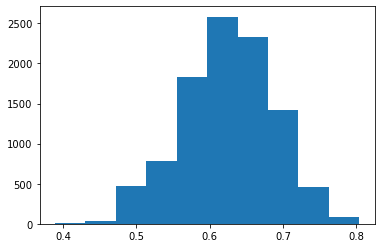

In [11]:
import ast
from scipy import stats
import dc_stat_think as dcst
import numpy as np
import matplotlib.pyplot as plt
# Add the label 13 which was missed in the splits
f1_score_list = []
support =[]
cr_dict = classification_report(test_labels, predictions, output_dict=True)
for cr_value_dict in cr_dict.values():
    if isinstance(cr_value_dict, dict):
        f1_score_list.append(cr_value_dict['f1-score'])
        support.append(cr_value_dict['support'])
f1_score_np = np.array(f1_score_list)
support_np = np.array(support)
#Bootstrap sampling to calculate the confidence interval for f1-score
def weighted_average(x, y):
    return np.sum(x * y)/np.sum(y)

def boostrap_weighted_avg(data,size):
    return dcst.draw_bs_pairs(data, support, weighted_average, size=size)
   
print(f1_score_np)    
print(support_np)
print(weighted_average(f1_score_np, support_np))
bs_weighted_avg = boostrap_weighted_avg(f1_score_np, 10000)
print(np.percentile(bs_weighted_avg, [2.5, 97.5]))
print(np.mean(bs_weighted_avg))
print(stats.sem(bs_weighted_avg, axis=None, ddof=0))
plt.hist(bs_weighted_avg)
plt.show()